# Outliers Detection Using Elliptic Envelope

In this notebook we will apply the Elliptic Envelope to detect outliers. The main assumption is that the data follow a Gausssian Distribution. 

Since this is a  case of outlier detection, we don’t have a clean data set representing the population of regular observations that can be used to train a model, like in the case of novelty detection.

In [65]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.font_manager
%matplotlib inline

## Data

We manually generate the data using numpy. In particular we generate normally distributed data and we add some outliers

In [19]:
# Parameters of the dataset
n_features = 2
n_samples = 150
n_outliers = 25

In [16]:
# Data Generation
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)

In [32]:
# Outliers Generation
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

## Exploratory Data Analysis

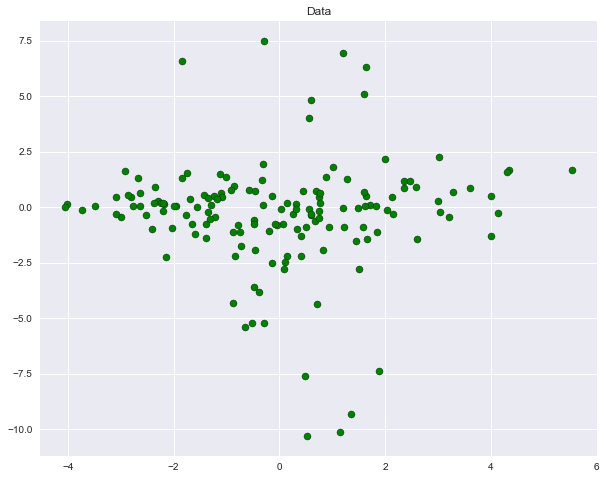

In [35]:
plt.figure(figsize=(10,8))
plt.title('Data')
plt.scatter(X[:,0], X[:,1], color='green', s=50, edgecolors='k')

## Elliptic Envelope

For Gaussian distributed data, the distance of an observation $x_i$ to the mode of the distribution can be computed using its Mahalanobis distance.

The Mahalanobis distance is a measure of the distance between a point P and a distribution D. This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis, the Mahalanobis distance measures the number of standard deviations from P to the mean of D.

Formula for Gaussian distributed data : 

$d_{(\mu,\Sigma)}(x_i)^2 = (x_i -
\mu)'\Sigma^{-1}(x_i - \mu)$ where $\mu$ and $\Sigma$ are the location and the covariance of the underlying Gaussian distribution.

In practice, $\mu$ and %\Sigma$ are replaced by some estimates. The usual covariance maximum likelihood estimate is very sensitive to the presence of outliers in the data set and therefor, the corresponding Mahalanobis distances are.

References:
- https://en.wikipedia.org/wiki/Mahalanobis_distance
- http://scikit-learn.org

### Minimum Covariance Determinant (MCD)
The Minimum Covariance Determinant estimator is a robust, high-breakdown point estimator of covariance.  It can be computed efficiently with the FAST-MCD algorithm of Rousseeuw and Van Driessen

References:
- P. J. Rousseeuw. Least median of squares regression. J. Am
Stat Ass, 79:871, 1984.

In [26]:
# Fit the MCD to the data
robust_cov = MinCovDet().fit(X)

In [27]:
# Empirical Covariance estimation
emp_cov = EmpiricalCovariance().fit(X)

## Results

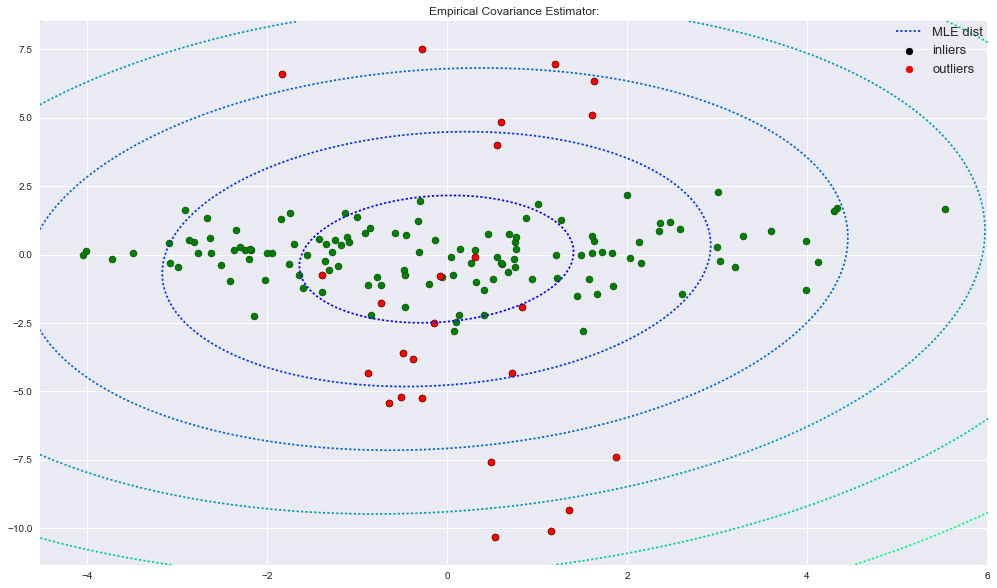

In [67]:
# Plot points
plt.figure(figsize=(17,10))
plt.scatter(X[:, 0], X[:, 1], color='green', label='inliers', s=50, edgecolors='k')
plt.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],color='red', label='outliers',  s=50, edgecolors='k')
plt.title("Empirical Covariance Estimator:")

# Plot contours
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100), np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

# Empirical contours
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_contour = plt.contour(xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.winter, linestyles='dotted')

# Legend
plt.legend([emp_contour.collections[1],inlier_plot, outlier_plot],['MLE dist', 'inliers', 'outliers'],
           loc="upper right", borderaxespad=0, prop=matplotlib.font_manager.FontProperties(size=13))


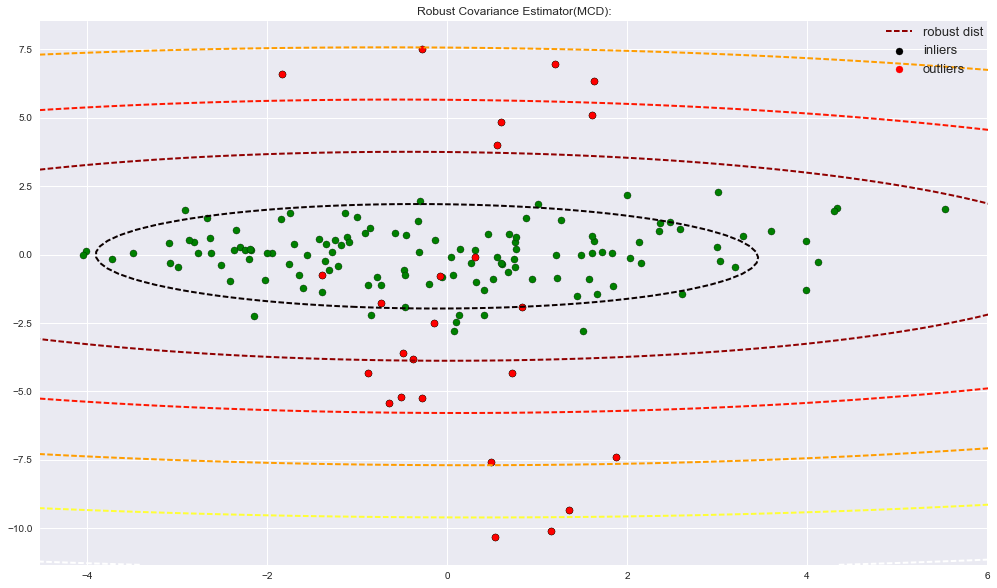

In [68]:
# Plot points
plt.figure(figsize=(17,10))
plt.scatter(X[:, 0], X[:, 1], color='green', label='inliers', s=50, edgecolors='k')
plt.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color='red', label='outliers',  s=50, edgecolors='k')
plt.title("Robust Covariance Estimator(MCD):")

# Plot contours
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100), np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

# MCD contour
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = plt.contour(xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.hot, linestyles='dashed', linewidths=2)

# Legend
plt.legend([robust_contour.collections[1], inlier_plot, outlier_plot],['robust dist', 'inliers', 'outliers'],
           loc="upper right", borderaxespad=0, prop=matplotlib.font_manager.FontProperties(size=13))

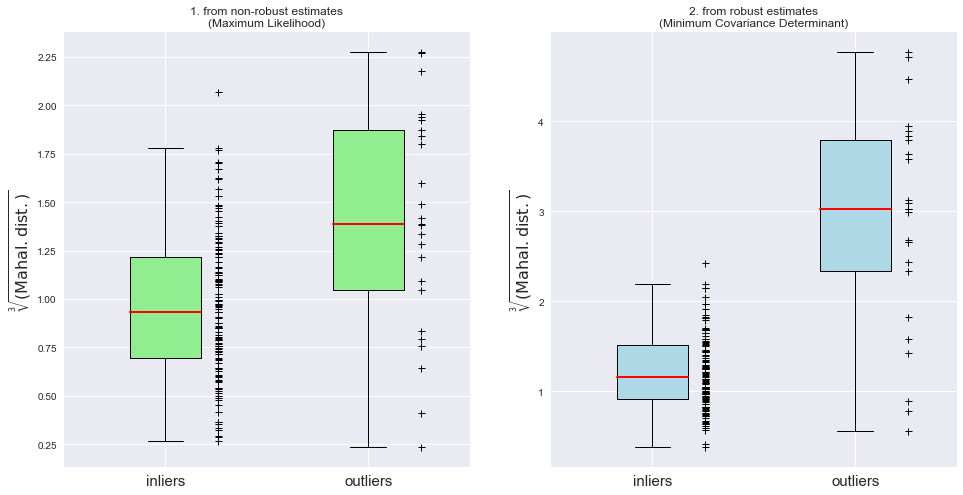

In [122]:
# Plot the scores for each point
plt.figure(figsize = (16,8))
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)

#Box plot empirical estimation
subfig1 = plt.subplot(1, 2, 1)
box1 = subfig1.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.35, patch_artist=True)
for box in zip(box1['boxes'],box1['medians']):
    box[0].set(facecolor='lightgreen')
    box[1].set(color='red', linewidth=2)
subfig1.plot(1.26 * np.ones(n_samples - n_outliers),emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig1.plot(2.26 * np.ones(n_outliers),emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig1.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig1.set_title("1. from non-robust estimates\n(Maximum Likelihood)")

#Box plot robust estimation
subfig2 = plt.subplot(1, 2, 2)
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
box2 = subfig2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],widths=.35, patch_artist=True)
for box in zip(box2['boxes'],box2['medians']):
    box[0].set(facecolor='lightblue')
    box[1].set(color='red', linewidth=2)
subfig2.plot(1.26 * np.ones(n_samples - n_outliers),robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig2.plot(2.26 * np.ones(n_outliers),robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig2.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")